# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

C:\Users\Stephanie\anaconda3\envs\ece1512\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  class_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, class_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Model creation

In [3]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
from tensorflow.keras import layers
 
cnn_model.add(layers.Conv2D(32,3,strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
cnn_model.add(layers.MaxPool2D(pool_size=(2,2),strides=1))
cnn_model.add(layers.Conv2D(64,3,strides=1,padding='same',activation='relu'))
cnn_model.add(layers.MaxPool2D(pool_size=(2,2),strides=2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(128,activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(128,activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(NUM_CLASSES))
##

#cnn_model.summary()


# Build fully connected student.
fc_model = tf.keras.Sequential()

# your code start from here for step 2

fc_model.add(layers.Flatten())
fc_model.add(layers.Dense(784,activation='relu'))
fc_model.add(layers.Dense(784,activation='relu'))
fc_model.add(layers.Dense(NUM_CLASSES))


# Teacher loss function

In [4]:
import keras
import numpy as np
@tf.function
def compute_teacher_loss(images, labels):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for classes.

  # your code start from here for step 3
 
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)
  
  cross_entropy_loss_value = loss(labels,class_logits)


  return cross_entropy_loss_value


# Student loss function

In [5]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc_model(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)
  
  cross_entropy_loss_value = loss(labels,student_class_logits).numpy()

  return ALPHA*cross_entropy_loss_value + (1-ALPHA)*distillation_loss_value

# Train and evaluation

In [6]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)
        #tape.watch(loss_value)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

  return num_correct / num_total


# Training models

In [7]:
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 97.70%
Epoch 2: Class_accuracy: 98.44%
Epoch 3: Class_accuracy: 98.76%
Epoch 4: Class_accuracy: 98.74%
Epoch 5: Class_accuracy: 98.95%
Epoch 6: Class_accuracy: 98.94%
Epoch 7: Class_accuracy: 99.02%
Epoch 8: Class_accuracy: 99.08%
Epoch 9: Class_accuracy: 99.16%
Epoch 10: Class_accuracy: 99.11%
Epoch 11: Class_accuracy: 99.18%
Epoch 12: Class_accuracy: 99.24%


<tf.Tensor: shape=(), dtype=float32, numpy=0.9924>

In [ ]:
##RESET MODEL

# Build fully connected student.
fc_model = tf.keras.Sequential()

fc_model.add(layers.Flatten())
fc_model.add(layers.Dense(784,activation='relu'))
fc_model.add(layers.Dense(784,activation='relu'))
fc_model.add(layers.Dense(NUM_CLASSES))


# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 2.5 #temperature hyperparameter

# your code start from here for step 5 

accuracy = train_and_evaluate(fc_model, compute_student_loss)

In [9]:
print(accuracy.numpy())

0.9857


In [ ]:
#fc_model.save(r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project B\Project_B_Supp\models\MNIST-stu.h5')

In [ ]:
fc_model = tf.keras.models.load_model(r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project B\Project_B_Supp\models\MNIST-stu.h5')

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
T = [1.,2.,4.,16.,32.,64.]
acc = []

for i in T:
    ##RESET MODEL

    # Build fully connected student.
    fc_model = tf.keras.Sequential()

    fc_model.add(layers.Flatten())
    fc_model.add(layers.Dense(784,activation='relu'))
    fc_model.add(layers.Dense(784,activation='relu'))
    fc_model.add(layers.Dense(NUM_CLASSES))


    DISTILLATION_TEMPERATURE = i #temperature hyperparameter

    acc.append(train_and_evaluate(fc_model, compute_student_loss).numpy())



Text(0.5, 0, 'Temperature')

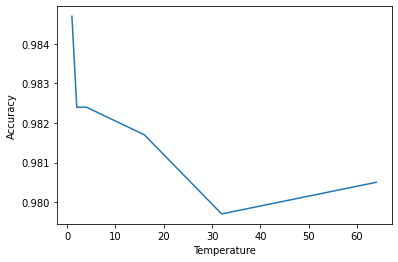

In [54]:
import matplotlib.pyplot as plt

plt.plot(T,acc)
plt.ylabel('Accuracy')
plt.xlabel('Temperature')

# Train student from scratch

In [13]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7

fc_model_no_distillation.add(layers.Flatten())
fc_model_no_distillation.add(layers.Dense(784,activation='relu'))
fc_model_no_distillation.add(layers.Dense(784,activation='relu'))
fc_model_no_distillation.add(layers.Dense(NUM_CLASSES))

#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over classes, but does not perform class distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_class_logits = fc_model_no_distillation(images, training=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=True)
  
  cross_entropy_loss = loss(labels,student_class_logits)
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.71%
Epoch 2: Class_accuracy: 97.05%
Epoch 3: Class_accuracy: 97.99%
Epoch 4: Class_accuracy: 97.76%
Epoch 5: Class_accuracy: 98.03%
Epoch 6: Class_accuracy: 98.04%
Epoch 7: Class_accuracy: 97.97%
Epoch 8: Class_accuracy: 97.80%
Epoch 9: Class_accuracy: 98.18%
Epoch 10: Class_accuracy: 98.19%
Epoch 11: Class_accuracy: 98.02%
Epoch 12: Class_accuracy: 97.78%


<tf.Tensor: shape=(), dtype=float32, numpy=0.9778>

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [14]:
# your code start from here for step 8
from keras_flops import get_flops

flops_teacher = get_flops(cnn_model, batch_size=BATCH_SIZE)
print(flops_teacher)
flops_student = get_flops(fc_model, batch_size=BATCH_SIZE)
print(flops_student)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


7766592000
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


633825792


# XAI method to explain models

In [79]:
from lime import lime_image
import matplotlib.pyplot as plt
j = 0
for images, labels in mnist_test:
    j += 1
    if j == 3:
        numpy_images = images.numpy()
        break


explainer = lime_image.LimeImageExplainer()

from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

def teacher_pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        grayimg = rgb2gray(tf.expand_dims(img,axis=2))
        logits = cnn_model(tf.expand_dims(grayimg, axis=0), training=False)
        probs = tf.nn.softmax(logits).numpy()
        tot_probs.append(probs[0])
    return tot_probs

def studentKD_pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        grayimg = rgb2gray(tf.expand_dims(img,axis=2))
        logits = fc_model(tf.expand_dims(grayimg, axis=0), training=False)
        probs = tf.nn.softmax(logits).numpy()
        tot_probs.append(probs[0])
    return tot_probs

def student_pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        grayimg = rgb2gray(tf.expand_dims(img,axis=2))
        logits = fc_model_no_distillation(tf.expand_dims(grayimg, axis=0), training=False)
        probs = tf.nn.softmax(logits).numpy()
        tot_probs.append(probs[0])
    return tot_probs

#print(pred_fn([gray2rgb(np.reshape(numpy_images[1],(28,28)))]))

#index = 3
#index = 21

index = 3

teacher_explanation = explainer.explain_instance(gray2rgb(np.reshape(numpy_images[index],(28,28))), classifier_fn=teacher_pred_fn)
teacher_img, teacher_mask = teacher_explanation.get_image_and_mask(np.argmax(labels[index].numpy()), num_features=64, hide_rest=True)
teacher_pred = np.argmax(cnn_model(images,training=False)[index].numpy())

studentKD_explanation = explainer.explain_instance(gray2rgb(np.reshape(numpy_images[index],(28,28))), classifier_fn=studentKD_pred_fn)
studentKD_img, studentKD_mask = studentKD_explanation.get_image_and_mask(np.argmax(labels[index].numpy()), num_features=64, hide_rest=True)
studentKD_pred = np.argmax(fc_model(images,training=False)[index].numpy())

student_explanation = explainer.explain_instance(gray2rgb(np.reshape(numpy_images[index],(28,28))), classifier_fn=student_pred_fn)
student_img, student_mask = student_explanation.get_image_and_mask(np.argmax(labels[index].numpy()), num_features=64, hide_rest=True)
student_pred = np.argmax(fc_model_no_distillation(images,training=False)[index].numpy())

100%|██████████| 1000/1000 [00:01<00:00, 772.36it/s]


[4, 4, 9]


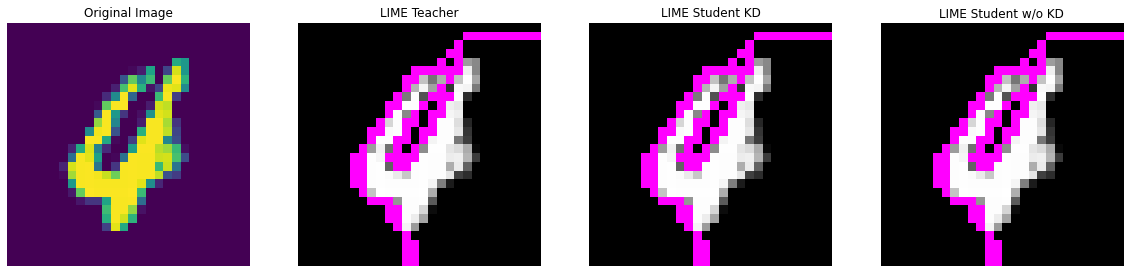

In [80]:
from skimage.segmentation import mark_boundaries

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(numpy_images[index])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(mark_boundaries(teacher_img, teacher_mask, color=(1, 0, 1)))
plt.axis('off')
plt.title('LIME Teacher')

plt.subplot(1,4,3)
plt.imshow(mark_boundaries(studentKD_img, studentKD_mask, color=(1, 0, 1)))
plt.axis('off')
plt.title('LIME Student KD')

plt.subplot(1,4,4)
plt.imshow(mark_boundaries(student_img, student_mask, color=(1, 0, 1)))
plt.axis('off')
plt.title('LIME Student w/o KD')

preds = [teacher_pred, studentKD_pred, student_pred]

print(preds)

[4, 4, 9]


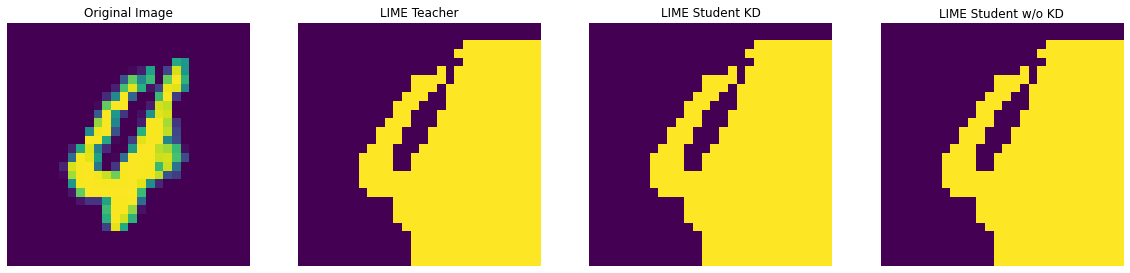

In [81]:
from skimage.segmentation import mark_boundaries

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(numpy_images[index])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(teacher_mask)
plt.axis('off')
plt.title('LIME Teacher')

plt.subplot(1,4,3)
plt.imshow(studentKD_mask)
plt.axis('off')
plt.title('LIME Student KD')

plt.subplot(1,4,4)
plt.imshow(student_mask)
plt.axis('off')
plt.title('LIME Student w/o KD')

preds = [teacher_pred, studentKD_pred, student_pred]

print(preds)

# Implementing the state-of-the-art KD algorithm

In [82]:
# your code start from here for step 13
# Build CNN teacher.
cnn2_model = tf.keras.Sequential()

# your code start from here for stpe 2
from tensorflow.keras import layers
 
cnn2_model.add(layers.Conv2D(32,3,strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
cnn2_model.add(layers.MaxPool2D(pool_size=(2,2),strides=1))
cnn2_model.add(layers.Conv2D(64,3,strides=1,padding='same',activation='relu'))
cnn2_model.add(layers.MaxPool2D(pool_size=(2,2),strides=2))
cnn2_model.add(layers.Flatten())
cnn2_model.add(layers.Dropout(0.5))
cnn2_model.add(layers.Dense(128,activation='relu'))
cnn2_model.add(layers.Dropout(0.5))
cnn2_model.add(layers.Dense(128,activation='relu'))
cnn2_model.add(layers.Dropout(0.5))
cnn2_model.add(layers.Dense(NUM_CLASSES))
##


In [83]:
import keras
import numpy as np
@tf.function
def compute_teacher_loss2(images, labels):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = cnn2_model(images, training=True)

  # Compute cross-entropy loss for classes.

  # your code start from here for step 3
 
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)
  
  cross_entropy_loss_value = loss(labels,class_logits)


  return cross_entropy_loss_value

In [84]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA2 = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE2 = 4. #temperature hyperparameter

ALPHA3 = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE3 = 4. #temperature hyperparameter


def compute_ta_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  ta_class_logits = ta_model(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = cnn2_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, ta_class_logits, DISTILLATION_TEMPERATURE2)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)
  
  cross_entropy_loss_value = loss(labels,ta_class_logits).numpy()

  return ALPHA2*cross_entropy_loss_value + (1-ALPHA2)*distillation_loss_value


def compute_student_loss2(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc2_model(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  ta_class_logits = ta_model(images, training=False)
  distillation_loss_value = distillation_loss(ta_class_logits, student_class_logits, DISTILLATION_TEMPERATURE3)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)
  
  cross_entropy_loss_value = loss(labels,student_class_logits).numpy()

  return ALPHA3*cross_entropy_loss_value + (1-ALPHA3)*distillation_loss_value

In [85]:
train_and_evaluate(cnn2_model, compute_teacher_loss2)

Epoch 1: Class_accuracy: 97.67%
Epoch 2: Class_accuracy: 98.44%
Epoch 3: Class_accuracy: 98.77%
Epoch 4: Class_accuracy: 98.77%
Epoch 5: Class_accuracy: 98.97%
Epoch 6: Class_accuracy: 99.15%
Epoch 7: Class_accuracy: 99.12%
Epoch 8: Class_accuracy: 99.08%
Epoch 9: Class_accuracy: 99.08%
Epoch 10: Class_accuracy: 99.00%
Epoch 11: Class_accuracy: 99.19%
Epoch 12: Class_accuracy: 99.16%


<tf.Tensor: shape=(), dtype=float32, numpy=0.9916>

In [88]:
# Hyperparameters for distillation (need to be tuned).
ALPHA2 = 0.55 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE2 = 3.2 #temperature hyperparameter

ta_model = tf.keras.Sequential()

ta_model.add(layers.Conv2D(64,3,strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
ta_model.add(layers.MaxPool2D(pool_size=(2,2),strides=1))
ta_model.add(layers.Flatten())
ta_model.add(layers.Dropout(0.5))
ta_model.add(layers.Dense(256,activation='relu'))
ta_model.add(layers.Dropout(0.5))
ta_model.add(layers.Dense(NUM_CLASSES))

train_and_evaluate(ta_model, compute_ta_loss)

Epoch 1: Class_accuracy: 97.74%
Epoch 2: Class_accuracy: 98.29%
Epoch 3: Class_accuracy: 98.47%
Epoch 4: Class_accuracy: 98.60%
Epoch 5: Class_accuracy: 98.65%
Epoch 6: Class_accuracy: 98.60%
Epoch 7: Class_accuracy: 98.66%
Epoch 8: Class_accuracy: 98.65%
Epoch 9: Class_accuracy: 98.77%
Epoch 10: Class_accuracy: 98.87%
Epoch 11: Class_accuracy: 98.86%
Epoch 12: Class_accuracy: 98.98%


<tf.Tensor: shape=(), dtype=float32, numpy=0.9898>

In [93]:
ALPHA3 = 0.48 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE3 = 3.5 #temperature hyperparameter

# Build fully connected student.
fc2_model = tf.keras.Sequential()

# your code start from here for step 2

fc2_model.add(layers.Flatten())
fc2_model.add(layers.Dense(784,activation='relu'))
fc2_model.add(layers.Dense(784,activation='relu'))
fc2_model.add(layers.Dense(NUM_CLASSES))

train_and_evaluate(fc2_model, compute_student_loss2)

Epoch 1: Class_accuracy: 96.02%
Epoch 2: Class_accuracy: 97.07%
Epoch 3: Class_accuracy: 97.41%
Epoch 4: Class_accuracy: 97.76%
Epoch 5: Class_accuracy: 97.99%
Epoch 6: Class_accuracy: 97.82%
Epoch 7: Class_accuracy: 98.14%
Epoch 8: Class_accuracy: 97.99%
Epoch 9: Class_accuracy: 98.09%
Epoch 10: Class_accuracy: 98.07%
Epoch 11: Class_accuracy: 98.28%
Epoch 12: Class_accuracy: 98.19%


<tf.Tensor: shape=(), dtype=float32, numpy=0.9819>